In [1]:
import os
os.chdir("utils")

In [2]:
# Initialization
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

raw_tr = pd.read_csv("../data/train.csv.zip")
raw_tr = raw_tr.replace(to_replace=-999, value=np.nan)

raw_te = pd.read_csv("../data/test.csv.zip")
raw_te = raw_te.replace(to_replace=-999, value=np.nan)

In [3]:
# Explore NaNs
nans = raw_tr.isnull() 
nan_cols = nans.sum(axis=0) / raw_tr.shape[0]
nan_rows = nans.sum(axis=1)

with pd.option_context('display.float_format','{:.4%}'.format):
     print("NaN column summary:\n{}\n".format(nan_cols[nan_cols > 0]))
     print("NaN row summary:\n{}".format(nan_rows[nan_rows > 0]))
     
print("\nShapes")
print("\traw: {}".format(raw_tr.shape))
print("\tdrop rows: {}".format(raw_tr.dropna(axis=0).shape))
print("\tdrop cols: {}".format(raw_tr.dropna(axis=1).shape))

NaN column summary:
DER_mass_MMC             15.2456%
DER_deltaeta_jet_jet     70.9828%
DER_mass_jet_jet         70.9828%
DER_prodeta_jet_jet      70.9828%
DER_lep_eta_centrality   70.9828%
PRI_jet_leading_pt       39.9652%
PRI_jet_leading_eta      39.9652%
PRI_jet_leading_phi      39.9652%
PRI_jet_subleading_pt    70.9828%
PRI_jet_subleading_eta   70.9828%
PRI_jet_subleading_phi   70.9828%
dtype: float64

NaN row summary:
1          7
2          8
3         10
4         10
7          7
          ..
249995    11
249996    11
249997     7
249998    10
249999    11
Length: 181886, dtype: int64

Shapes
	raw: (250000, 32)
	drop rows: (68114, 32)
	drop cols: (250000, 21)


In [4]:
################################################################################
# Prepare data and labels
################################################################################

# Drop rows with NaNs
#data = raw.dropna(axis=0)

# Drop columns with NaNs
#data = raw.dropna(axis=1)

# Replace NaNs with mean of the column
#means = raw_tr.means()
#train = raw_tr.fillna(means)
#test = raw_te.fillna(means)

# Signal = 1, Background = 0
train = raw_tr.replace({'s':1,'b':0})
test = raw_te.replace({'s':1,'b':0})

# Split data and labels
X = train.drop(columns=['Id','Prediction'])
y = train['Prediction']

# Standarize data
X = (X-X.mean())/X.std()

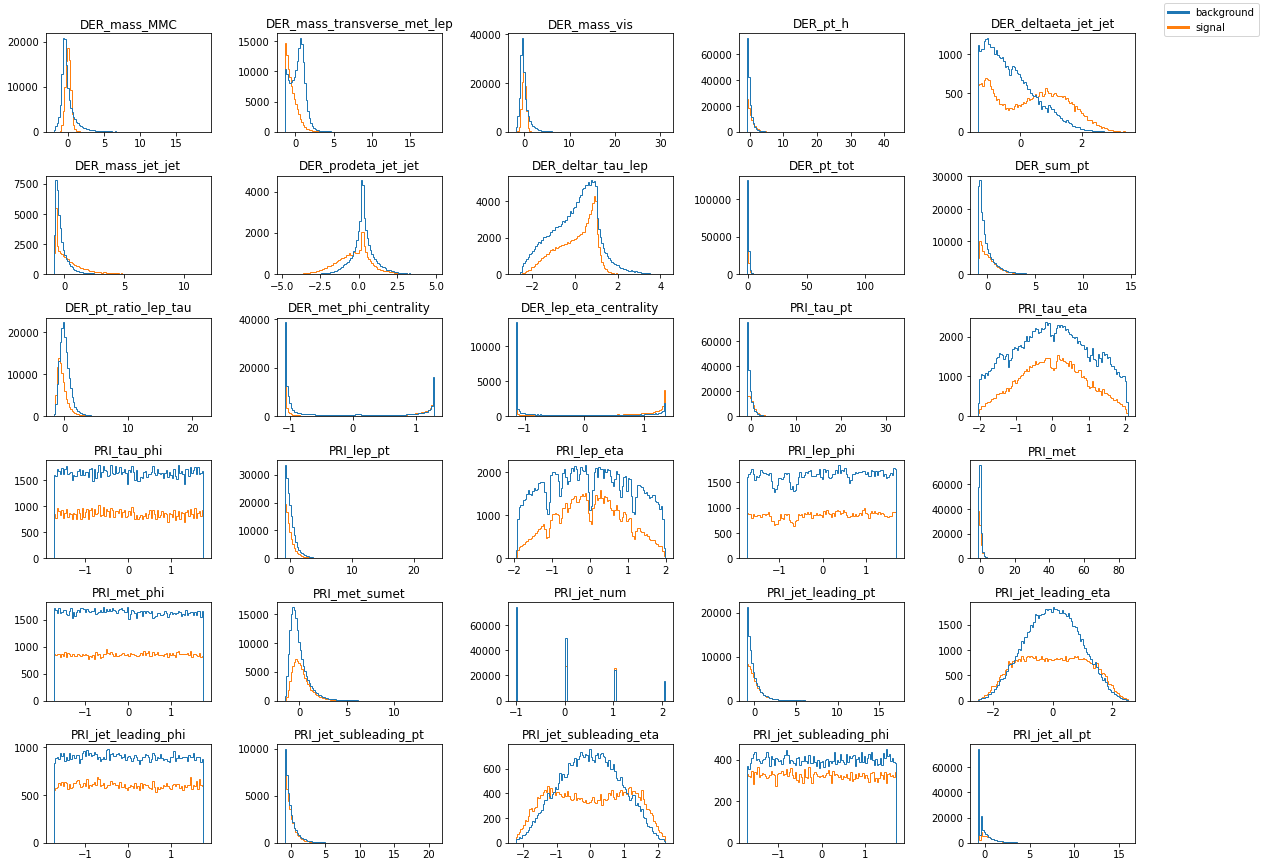

In [5]:
from matplotlib.lines import Line2D
def plot_histogram(y, X):
    mask = (y == 0)
    labels = ("background","signal")
    n = X.shape[1]

    nrows = (n+4)//5
    ncols = 5

    fig, axs = plt.subplots(nrows, ncols, figsize=(16,12))

    for k, name in enumerate(X):
        row = k // ncols
        col = k % ncols
        axs[row, col].hist([X[name][mask], X[name][~mask]], 
                 label=labels, 
                 bins=100, 
                 histtype='step');
        axs[row, col].set_title(name)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    fig.legend(lines, labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    fig.tight_layout()

plot_histogram(y, X)

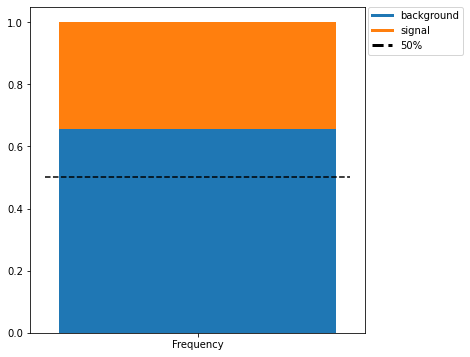

In [6]:
def plot_bar_counts(y, X):
    width = 0.5
    idx = (1,)
    labels = ("background","signal","50%")

    vals, counts = np.unique(y, return_counts=True)
    assert (len(vals) == 2)

    b = counts[vals == 0] / y.shape[0]
    s = counts[vals == 1] / y.shape[0]

    plt.figure(figsize=(6,6))
    plt.bar(idx, b, width)
    plt.bar(idx, s, width, bottom=b)
    plt.xticks(idx, ('Frequency',))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]

    left, right = plt.xlim()
    plt.hlines(0.5, left, right, linestyle='--')
    colors.append('black')
    lines.append(Line2D([0], [0], color='black', linewidth=3, linestyle='--'))

    plt.legend(lines, labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plot_bar_counts(y, X)

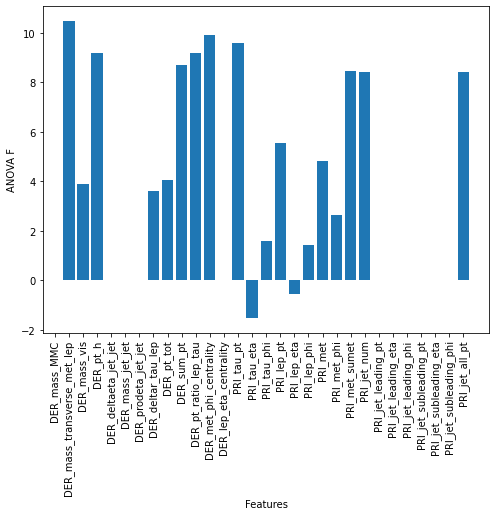

In [7]:
from scipy import stats

# ANOVA:
#  - https://dzone.com/articles/correlation-between-categorical-and-continuous-var-1

corr = np.empty(train.shape[1]-2)
cols = [col for col in train.drop(columns=['Id','Prediction'])]
    
for j, col in enumerate(cols):
    F, p = stats.f_oneway(train[train['Prediction']==0][col],
                              train[train['Prediction']==1][col])
    corr[j] = F

idx = np.arange(corr.shape[0])
plt.figure(figsize=(8,6))
plt.bar(idx, np.log(corr))
plt.xticks(idx, cols, rotation=90)
plt.xlabel('Features')
plt.ylabel('ANOVA F')
plt.show()

## Prepare Features



In [8]:
from data import build_poly, prepare_feautres

## Hyper-Parameter Selection



In [9]:
from abc import ABC, abstractmethod
from implementations import reg_logistic_regression
from costs import reg_logistic_error
from helpers import sigmoid

class Classifier(ABC):
    """Metaclass for classifier classes."""

    def __init__(self):
        pass

    @abstractmethod
    def fit(self, y, tx):
        raise NotImplementedError

    @abstractmethod
    def predict(self, w, tx):
        raise NotImplementedError

    @abstractmethod
    def compute_loss(self, y, tx, w):
        raise NotImplementedError
    

class RegularizedLogisticRegression(Classifier):
    """Implementation of regularized logistic regression."""

    def __init__(self, gamma, lambda_, reg, max_iters=1000, early_stopping=True, tol=0.0001, patience=10):
        self.gamma = gamma
        self.lambda_ = lambda_
        self.reg = reg
        self.early_stopping = early_stopping,
        self.tol = tol,
        self.patience = patience
        self.max_iters = max_iters

    def fit(self, y, tx):
        return self.__reg_logistic_regression(y, tx)

    def predict(self, w, oos):
        return np.rint(sigmoid(oos @ w))

    def __reg_logistic_regression(self, y, tx):

        return reg_logistic_regression(
            y=y,
            tx=tx,
            lambda_=self.lambda_,
            reg=self.reg,
            initial_w=np.zeros((tx.shape[1])),
            max_iters=self.max_iters,
            gamma=self.gamma,
            early_stopping=self.early_stopping,
            tol=self.tol,
            patience=self.patience
        )

    def compute_loss(self, y, tx, w):
        
        return reg_logistic_error(
            y=y,
            tx=tx,
            w=w,
            lambda_=self.lambda_,
            reg=self.reg
        )

In [24]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def prepare_split_data(y, tx, degree, k_fold, seed):
    """
    Split the dataset based on k-fold cross validation and prepare features. 
    Returns the k splits.
    """
    k_indices = build_k_indices(y, k_fold, seed)
    
    tx_trs = []
    y_trs = []
    tx_tes = []
    y_tes = []
    
    for k in range(k_fold):
        # get k-th subgroup in test, others in train
        mask = np.full((y.shape[0]), False, dtype=bool)
        mask[k_indices[k]] = True
    
        y_te = y[mask]
        tx_te = tx[mask]
    
        mask = ~mask
        y_tr = y[mask]
        tx_tr = tx[mask]
        
        # Replace NaNs and standarize
        tx_tr, mean, std, mean_nan, _ = prepare_feautres(tx_tr, degree)
        tx_te, _, _, _, _ = prepare_feautres(tx_te, degree, mean_nan, mean, std)
        
        tx_trs.append(tx_tr)
        y_trs.append(y_tr)
        tx_tes.append(tx_te)
        y_tes.append(y_te)
    
    return y_trs, tx_trs, y_tes, tx_tes

In [11]:
from cross_validation import *

def cross_validation(y_tr, tx_tr, y_te, tx_te, comb, verbose=2):
    # instantiate the the classifier
    clf = RegularizedLogisticRegression(**comb, max_iters=200, tol=0.001, patience=5)
    # fit the model
    w, loss = clf.fit(y_tr, tx_tr)
    # calculate the loss for train and test data
    loss_tr = clf.compute_loss(y_tr, tx_tr, w)
    loss_te = clf.compute_loss(y_te, tx_te, w)
    # compute performance metrics
    p = clf.predict(w, tx_te)
    f1 = f1_score(y_te, p)
    acc = accuracy(y_te, p)
        
    return loss_tr, loss_te, f1, acc

In [35]:
import itertools as it

def model_selection(y, tx, k_fold, degree, grid, seed, verbose=2):
    
    max_loss = np.finfo(float).min
    max_acc = np.finfo(float).min

    # Generate total permuations of hps for gridsearch
    k, v = zip(*grid.items())
    permutations = [dict(zip(k, values)) for values in it.product(*v)]
    losses = {
        "loss_tr": [],
        "loss_te": [],
        "f1_te": [],
        "acc_te": []
    }
    
    print(f'Training on {int((1-1/k_fold)*y.shape[0])} samples')
    for permutation in permutations:
        print(f'Seed: {seed}, Permutation: {str(permutation)}')
        y_trs, tx_trs, y_tes, tx_tes = prepare_split_data(y, tx, degree, k_fold, seed)
        # Cross validation
        trl = 0.0
        tel = 0.0
        f1 = 0.0
        acc = 0.0
        for k in range(k_fold):
            tr, te, f1l, accl = cross_validation(
                y_trs[k],
                tx_trs[k],
                y_tes[k],
                tx_tes[k],
                comb=permutation
            )
            trl += tr
            tel += te
            f1 += f1l
            acc += accl

            if verbose > 1: print(f'\t\t\tTR={tr:.4e} | TE={te:.4e} | F1:{f1l:.4f} | ACC:{accl:.4f}')
                    
            if ~np.all(np.isfinite((tr, te, f1, acc))): break
        
        # k+1 needed to account for early exit due to NaNs or infs.
        losses["loss_tr"].append(trl / (k+1))
        losses["loss_te"].append(tel / (k+1))
        losses["f1_te"].append(f1 / (k+1))
        losses["acc_te"].append(acc / (k+1))
        
        if verbose > 0: print('\t'+' | '.join([ f'{key} = {val[-1]:.4f}' for key, val in losses.items() ]))

    idx = np.argmax(losses["acc_te"])
    print(f'\nMINIMUMS:')
    print(f'\tBest parameters: {str(permutations[idx])}')
    print(f'\tAccuracy: {losses["acc_te"][idx]:.4f}')
    print(f'\tF1-score: {losses["f1_te"][idx]:.4f}')
    print(f'\tLoss: {losses["loss_te"][idx]:.4e}')
    
    return permutations[idx]

In [42]:
grid = {
    "gamma": np.logspace(-1, 0, 10),
    "lambda_": np.logspace(-3, 0, 10),
    "reg": [2]
}
seed = 42
reg = 2 # L2 regularization
k_fold = 4
verbose = 2

degree = 3

tx = np.asarray(train.drop(columns=['Id','Prediction']))
y = np.asarray(train['Prediction'])
params = model_selection(
    y=y,
    tx=tx,
    k_fold=k_fold,
    degree=degree,
    grid=grid,
    seed=seed,
    verbose=verbose
)

Training on 187500 samples
Seed: 42, Permutation: {'gamma': 0.1, 'lambda_': 0.001, 'reg': 2}
Stopped after 98 it.
			TR=4.9706e-01 | TE=4.9612e-01 | F1:0.6133 | ACC:0.7608
Stopped after 97 it.
			TR=4.9781e-01 | TE=4.9766e-01 | F1:0.6116 | ACC:0.7594
Stopped after 97 it.
			TR=4.9763e-01 | TE=4.9856e-01 | F1:0.6124 | ACC:0.7583
Stopped after 98 it.
			TR=4.9700e-01 | TE=4.9800e-01 | F1:0.6144 | ACC:0.7591
	loss_tr = 0.4974 | loss_te = 0.4976 | f1_te = 0.6129 | acc_te = 0.7594
Seed: 42, Permutation: {'gamma': 0.1, 'lambda_': 0.0021544346900318843, 'reg': 2}
Stopped after 95 it.
			TR=4.9946e-01 | TE=4.9852e-01 | F1:0.6132 | ACC:0.7604
Stopped after 94 it.
			TR=5.0018e-01 | TE=5.0004e-01 | F1:0.6114 | ACC:0.7587
Stopped after 94 it.
			TR=5.0000e-01 | TE=5.0092e-01 | F1:0.6124 | ACC:0.7577
Stopped after 95 it.
			TR=4.9939e-01 | TE=5.0038e-01 | F1:0.6144 | ACC:0.7588
	loss_tr = 0.4998 | loss_te = 0.5000 | f1_te = 0.6129 | acc_te = 0.7589
Seed: 42, Permutation: {'gamma': 0.1, 'lambda_': 

Stopped after 20 it.
			TR=6.0035e-01 | TE=6.0055e-01 | F1:0.5988 | ACC:0.7300
Stopped after 20 it.
			TR=6.0018e-01 | TE=6.0093e-01 | F1:0.5965 | ACC:0.7288
	loss_tr = 0.6003 | loss_te = 0.6003 | f1_te = 0.5965 | acc_te = 0.7297
Seed: 42, Permutation: {'gamma': 0.1291549665014884, 'lambda_': 0.46415888336127775, 'reg': 2}
Stopped after 12 it.
			TR=6.2708e-01 | TE=6.2643e-01 | F1:0.5858 | ACC:0.7203
Stopped after 12 it.
			TR=6.2723e-01 | TE=6.2745e-01 | F1:0.5835 | ACC:0.7164
Stopped after 12 it.
			TR=6.2731e-01 | TE=6.2729e-01 | F1:0.5878 | ACC:0.7184
Stopped after 12 it.
			TR=6.2710e-01 | TE=6.2778e-01 | F1:0.5850 | ACC:0.7161
	loss_tr = 0.6272 | loss_te = 0.6272 | f1_te = 0.5855 | acc_te = 0.7178
Seed: 42, Permutation: {'gamma': 0.1291549665014884, 'lambda_': 1.0, 'reg': 2}
Stopped after 7 it.
			TR=6.4977e-01 | TE=6.4932e-01 | F1:0.5744 | ACC:0.7089
Stopped after 7 it.
			TR=6.4992e-01 | TE=6.5013e-01 | F1:0.5735 | ACC:0.7048
Stopped after 7 it.
			TR=6.5002e-01 | TE=6.4983e-01

Stopped after 44 it.
			TR=5.2221e-01 | TE=5.2323e-01 | F1:0.6127 | ACC:0.7563
	loss_tr = 0.5225 | loss_te = 0.5226 | f1_te = 0.6117 | acc_te = 0.7566
Seed: 42, Permutation: {'gamma': 0.21544346900318834, 'lambda_': 0.046415888336127774, 'reg': 2}
Stopped after 32 it.
			TR=5.4434e-01 | TE=5.4345e-01 | F1:0.6099 | ACC:0.7517
Stopped after 32 it.
			TR=5.4457e-01 | TE=5.4453e-01 | F1:0.6096 | ACC:0.7511
Stopped after 32 it.
			TR=5.4448e-01 | TE=5.4508e-01 | F1:0.6103 | ACC:0.7500
Stopped after 32 it.
			TR=5.4427e-01 | TE=5.4520e-01 | F1:0.6114 | ACC:0.7505
	loss_tr = 0.5444 | loss_te = 0.5446 | f1_te = 0.6103 | acc_te = 0.7508
Seed: 42, Permutation: {'gamma': 0.21544346900318834, 'lambda_': 0.1, 'reg': 2}
Stopped after 22 it.
			TR=5.7100e-01 | TE=5.7014e-01 | F1:0.6049 | ACC:0.7431
Stopped after 22 it.
			TR=5.7116e-01 | TE=5.7122e-01 | F1:0.6055 | ACC:0.7424
Stopped after 22 it.
			TR=5.7112e-01 | TE=5.7156e-01 | F1:0.6080 | ACC:0.7429
Stopped after 22 it.
			TR=5.7098e-01 | TE=5.71

Stopped after 50 it.
			TR=4.9262e-01 | TE=4.9154e-01 | F1:0.6187 | ACC:0.7667
Stopped after 50 it.
			TR=4.9319e-01 | TE=4.9291e-01 | F1:0.6177 | ACC:0.7654
Stopped after 50 it.
			TR=4.9303e-01 | TE=4.9398e-01 | F1:0.6160 | ACC:0.7638
Stopped after 50 it.
			TR=4.9258e-01 | TE=4.9423e-01 | F1:0.6195 | ACC:0.7653
	loss_tr = 0.4929 | loss_te = 0.4932 | f1_te = 0.6180 | acc_te = 0.7653
Seed: 42, Permutation: {'gamma': 0.35938136638046275, 'lambda_': 0.01, 'reg': 2}
Stopped after 41 it.
			TR=5.0387e-01 | TE=5.0292e-01 | F1:0.6146 | ACC:0.7633
Stopped after 41 it.
			TR=5.0440e-01 | TE=5.0420e-01 | F1:0.6139 | ACC:0.7622
Stopped after 41 it.
			TR=5.0426e-01 | TE=5.0513e-01 | F1:0.6134 | ACC:0.7609
Stopped after 41 it.
			TR=5.0388e-01 | TE=5.0506e-01 | F1:0.6167 | ACC:0.7625
	loss_tr = 0.5041 | loss_te = 0.5043 | f1_te = 0.6147 | acc_te = 0.7622
Seed: 42, Permutation: {'gamma': 0.35938136638046275, 'lambda_': 0.021544346900318832, 'reg': 2}
Stopped after 32 it.
			TR=5.2057e-01 | TE=5.1

Stopped after 6 it.
			TR=1.8367e+00 | TE=1.8389e+00 | F1:0.4556 | ACC:0.6313
Stopped after 6 it.
			TR=1.8384e+00 | TE=1.8364e+00 | F1:0.4577 | ACC:0.6332
Stopped after 6 it.
			TR=1.8454e+00 | TE=1.8470e+00 | F1:0.4528 | ACC:0.6301
	loss_tr = 1.8557 | loss_te = 1.8553 | f1_te = 0.4552 | acc_te = 0.6322
Seed: 42, Permutation: {'gamma': 0.5994842503189409, 'lambda_': 0.001, 'reg': 2}
Stopped after 51 it.
			TR=4.7769e-01 | TE=4.7649e-01 | F1:0.6292 | ACC:0.7733
Stopped after 52 it.
			TR=4.7788e-01 | TE=4.7737e-01 | F1:0.6276 | ACC:0.7712
Stopped after 53 it.
			TR=4.7737e-01 | TE=4.7859e-01 | F1:0.6271 | ACC:0.7707
Stopped after 49 it.
			TR=4.7805e-01 | TE=4.7981e-01 | F1:0.6284 | ACC:0.7709
	loss_tr = 0.4777 | loss_te = 0.4781 | f1_te = 0.6281 | acc_te = 0.7715
Seed: 42, Permutation: {'gamma': 0.5994842503189409, 'lambda_': 0.0021544346900318843, 'reg': 2}
Stopped after 46 it.
			TR=4.8222e-01 | TE=4.8080e-01 | F1:0.6256 | ACC:0.7710
Stopped after 48 it.
			TR=4.8216e-01 | TE=4.8172

Stopped after 9 it.
			TR=8.3822e-01 | TE=8.3631e-01 | F1:0.5123 | ACC:0.5735
	loss_tr = 0.8415 | loss_te = 0.8418 | f1_te = 0.5089 | acc_te = 0.5722
Seed: 42, Permutation: {'gamma': 0.774263682681127, 'lambda_': 0.21544346900318823, 'reg': 2}
Stopped after 6 it.
			TR=1.4049e+00 | TE=1.4011e+00 | F1:0.4778 | ACC:0.6445
Stopped after 6 it.
			TR=1.3478e+00 | TE=1.3513e+00 | F1:0.4806 | ACC:0.6418
Stopped after 6 it.
			TR=1.3504e+00 | TE=1.3470e+00 | F1:0.4846 | ACC:0.6444
Stopped after 6 it.
			TR=1.3539e+00 | TE=1.3574e+00 | F1:0.4766 | ACC:0.6397
	loss_tr = 1.3643 | loss_te = 1.3642 | f1_te = 0.4799 | acc_te = 0.6426
Seed: 42, Permutation: {'gamma': 0.774263682681127, 'lambda_': 0.46415888336127775, 'reg': 2}
Stopped after 6 it.
			TR=2.7911e+00 | TE=2.7869e+00 | F1:0.4555 | ACC:0.6348
Stopped after 6 it.
			TR=2.6999e+00 | TE=2.6989e+00 | F1:0.4569 | ACC:0.6320
Stopped after 6 it.
			TR=2.7003e+00 | TE=2.7002e+00 | F1:0.4585 | ACC:0.6338
Stopped after 6 it.
			TR=2.7111e+00 | TE=2.

In [ ]:
# Save expensive computation
#%store all_loss all_f1 all_acc min_gamma min_lambda
#%store -r all_loss all_f1 all_acc min_gamma min_lambda

#MINIMUMS:
#   lambda=1.0000e-02
#   gamma=5.9948e-01
#   Test loss=1.2879e+00
#   Accuracy=0.7725

## Train



In [242]:
# Prepare training and test data
tx_tr = np.asarray(train.drop(columns=['Id','Prediction']))
y_tr = np.asarray(train['Prediction'])

tx_te = np.asarray(test.drop(columns=['Id','Prediction']))

tx_tr, mean, std, mean_nan, nan_cols = prepare_feautres(tx_tr, degree)
tx_te, _, _, _, _ = prepare_feautres(tx_te, degree, mean_nan, mean, std)

# Train model
clf = RegularizedLogisticRegression(**params, max_iters = 1000, tol = 0.0001, patience = 20)
w, loss = clf.fit(y_tr, tx_tr)
loss_tr = clf.compute_loss(y_tr, tx_tr, w)
y_pred = clf.predict(w, tx_tr)

# Report results
f1 = f1_score(y_tr, y_pred)
acc = accuracy(y_tr, y_pred)

print('RESULTS:')
print(f'\tLoss:     {loss_tr:.4e}')
print(f'\tF1 score: {f1:.4f}')
print(f'\tAccuracy: {acc:.4f}')

Stopped after 794 it.
RESULTS:
	Loss:     4.4489e-01
	F1 score: 0.6752
	Accuracy: 0.7946


## Explore result



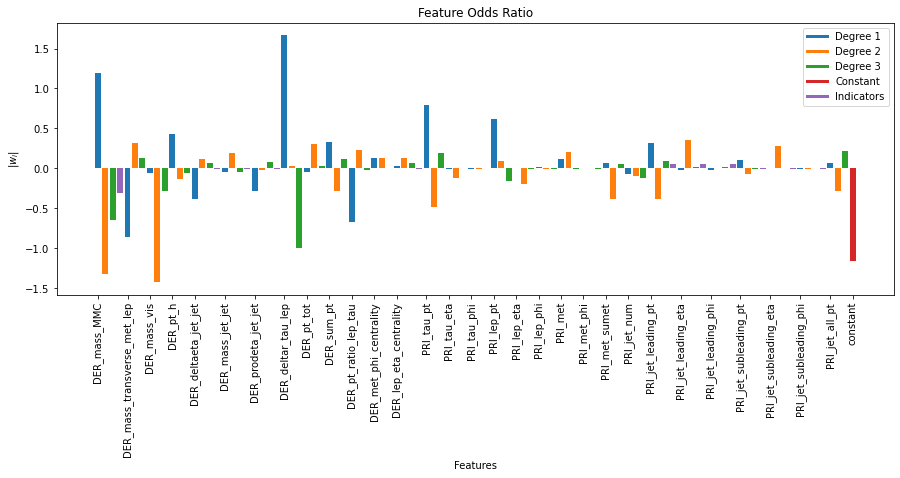

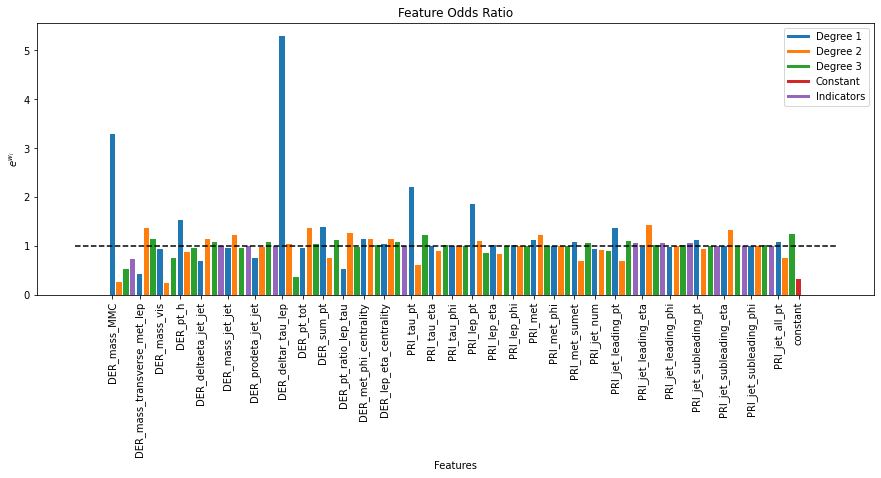

In [248]:
from itertools import cycle

def feature_labels_full(df, nan_cols, degree):
    col_names = [col for col in df.drop(columns=['Id','Prediction'])]
    nan_labels = [f'IND:{col}' for col in train.drop(columns=['Id','Prediction']).iloc[:,nan_cols]]
    
    poly_labels = []
    for name in col_names:
        for d in range(1,degree+1):
            poly_labels.append(f'{name}^{d}')
    
    labels = poly_labels + ['constant'] + nan_labels
    idx = np.arange(len(labels)) 
    
    return idx, labels

def feature_labels_sparse(w, df, nan_cols, degree):  
    col_names = [col for col in df.drop(columns=['Id','Prediction'])]
    labels = col_names + ['constant']
    
    count = np.full(len(labels), degree)
    count[nan_cols] += 1
    count[-1] = 1
    
    # Location of labels
    idx = np.zeros(len(labels))
    idx[1:] = np.cumsum(count)[:-1]
    
    # How to permute w
    start_indicators = w.shape[0] - nan_cols.shape[0]
    perm = np.arange(w.shape[0])
    # Indicator columns have same index as highest degree column
    perm[start_indicators:] = ((nan_cols+1)*degree - 1)
    perm = np.argsort(perm, kind='stable')
    
    # Color sequence
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    colors = [ next(color_cycle) for i in range(degree) ]*len(col_names)
    colors += [ next(color_cycle) ]
    colors += [ next(color_cycle) ]*len(nan_cols)
    colors = np.array(colors)
    colors = colors[perm]
    
    return idx, labels, perm, colors

def plot_weights(w, df, nan_cols, degree, ylabel):
    idx, labels, perm, color = feature_labels_sparse(w, train, nan_cols, degree)
    
    # Plot
    fig = plt.figure(figsize=(15,5))
    plt.bar(np.arange(w.shape[0]), w[perm], color=color)
    
    plt.xticks(idx, labels, rotation=90)
    plt.xlabel('Features')
    plt.ylabel(ylabel)
    plt.title('Feature Odds Ratio')
    
    # Legend
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    lines = [Line2D([0], [0], color=next(color_cycle), linewidth=3, linestyle='-') for i in range(degree+2)]
    labels = [ f'Degree {i+1}' for i in range(degree)] + ['Constant'] + ['Indicators']
    plt.legend(lines, labels, loc='best')

# Plot feature weights
plot_weights(w, train, nan_cols, degree, '$|w_i|$')

# Plot feature odds ratio
#  See: https://christophm.github.io/interpretable-ml-book/logistic.html#logistic
plot_weights(np.exp(w), train, nan_cols, degree, '$e^{w_i}$')
left, right = plt.xlim()
plt.hlines(1.0, left, right, linestyle='--');

In [48]:
idx, labels = feature_labels_full(train, nan_cols, degree)
odds_ratio = np.exp(w)
perm = np.argsort(-abs(1-odds_ratio))
for i in range(w.shape[0]):
    print(f'{labels[perm[i]]:30s} = {odds_ratio[perm[i]]-1:7.4f}')

DER_deltar_tau_lep^1           =  2.4067
DER_mass_MMC^1                 =  1.3223
PRI_tau_pt^1                   =  1.0054
constant                       = -0.6479
DER_mass_vis^2                 = -0.6456
PRI_lep_pt^1                   =  0.6361
DER_mass_MMC^2                 = -0.5984
DER_mass_transverse_met_lep^1  = -0.5475
DER_deltar_tau_lep^3           = -0.4989
DER_pt_ratio_lep_tau^1         = -0.4151
DER_mass_MMC^3                 = -0.3975
PRI_jet_leading_eta^2          =  0.3949
DER_pt_h^1                     =  0.3549
DER_sum_pt^1                   =  0.3023
PRI_tau_pt^2                   = -0.2752
PRI_jet_subleading_eta^2       =  0.2660
IND:DER_mass_MMC               = -0.2595
DER_deltaeta_jet_jet^1         = -0.2562
PRI_met_sumet^2                = -0.2497
PRI_jet_leading_pt^1           =  0.2485
PRI_jet_leading_pt^2           = -0.2375
DER_mass_vis^3                 = -0.2258
DER_pt_tot^2                   =  0.2184
DER_mass_transverse_met_lep^2  =  0.2131
DER_prodeta_jet_

## Generate submission



In [244]:
from helpers import create_csv_submission
import importlib

ids = test['Id']
y_pred = np.rint(sigmoid(tx_te @ w))
y_pred[y_pred == 0] = -1
y_pred[y_pred == 1] = 1

create_csv_submission(ids, y_pred, '../submission.csv')

## Notes



## It seems that adding the missing value indicators makes the method more "consitent with expectation". That is, the test loss and accuracy now follow similar patterns (both go up/down together). Without them, the highest accuracy tended to be where the test loss "blew up" (inf or nan).

